# Beyond the Pipeline - Charts and Analysis
Author A, Author B.


## Charts generated by this document
* ~US-wide faculty diversity, set against demographic projections~
* Candidate pool trends since 2012 (combining NSF survey of earned doctorates with IPEDS data)
* Charts showing distribution of trends for instituion groups:
    * Ivy+ (Chetty)
    * R1 (Carnegie)
    * National Liberal Arts Colleges (US News)
* Illustration of selected institutions, in context of their peers


References:
* [Data preparation code](github.com/natematias/ipeds-data-analysis)


In [570]:
library(ggplot2)
library(MASS) # includes CrossTable, should we need it
library(lme4)     # random intercepts
library(lmerTest) # random intercepts significance testing
library(plm)       # fixed effects models
library(stringr)
library(grid)
library(gridExtra) #arrange charts in a grid layout
library(fs)
library(gmodels) # contains CrossTable
library(xtable)
library(readxl)

#color-blind palette
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")


In [571]:
data.path = "/Users/nathan/Box/Projects/"
nces.path = "2021-NCES-Faculty-Data/"
nsed.path = "2021-NSF-Survey-Earned-Doctorates/"

## this generation date includes 2020-2021 
generation.date ="20220109"

year.df <- read.csv(paste(data.path, nces.path, generation.date, "_year_summary_table.csv", sep=""),na.strings = "")

image.dir <- "../figures/"

projection.end.year = 2060
projection.begin.year = 2013

In [572]:
## generate percentage of black, latino, american indian, alaska native

year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum <- 
    year.df$tenured_un_tenured_American_Indian_or_Alaska_Native_total_sum +
    year.df$tenured_un_tenured_Black_or_African_American_total_sum +
    year.df$tenured_un_tenured_Hispanic_or_Latino_total_sum +
    year.df$tenured_un_tenured_Native_Hawaiian_or_Other_Pacific_Islander_total_sum +
    year.df$tenured_un_tenured_Two_or_more_races_total_sum

year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct <- 
    year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum / 
    year.df$tenured_un_tenured_Grand_total_sum

# Plot US-wide tenure-track faculty diversity against demographic projections

Based on the [2017 US census population projections](https://www.census.gov/data/tables/2017/demo/popproj/2017-summary-tables.html), the rate of change in the above demographics is an increase (in proportion) of 0.002 (or 2 tenths of a percentage point) per year through 2060.



### Record Demographic Percentages
Source: [US 2020 census](https://www.census.gov/quickfacts/fact/table/US/PST045219)

* Black or African American: 13.4%
* American Indian and Alaska Native: 1.3%
* Native Hawaiian and Other Pacific Islander: 0.2%
* Hispanic or Latino: 18.5%
* Two or more races: 2.8%
* **Total**: 36.2

In [573]:
urm.prop <- .362
## now let's adjust for the percentage of faculty who are nonresident aliens

urm.prop.adjusted = (urm.prop * (1-mean(year.df$tenured_un_tenured_Nonresident_alien_total_pct)/100))

### Estimate linear model of change
If you are wondering about goodness of fit, observe that the R2 is 0.99. It's definitely a linear trend.

In [574]:
year.df$year.zeroed <- year.df$year-projection.begin.year
summary(linear.m1 <- lm(tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~ year.zeroed, data=year.df))


Call:
lm(formula = tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~ 
    year.zeroed, data = year.df)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.452e-04 -3.495e-04  3.956e-05  4.305e-04  6.628e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.136e-01  3.659e-04  310.42 7.54e-14 ***
year.zeroed 2.335e-03  8.747e-05   26.69 1.83e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005669 on 6 degrees of freedom
Multiple R-squared:  0.9916,	Adjusted R-squared:  0.9903 
F-statistic: 712.5 on 1 and 6 DF,  p-value: 1.826e-07


In [575]:
### estimate faculty diversity through 2060
### the last year that the US government provides
### race/ethnicity demographic projections

years.to.projection.end <- projection.end.year-projection.begin.year
projection.2060.df <- data.frame(
    year = c(projection.begin.year, projection.end.year),
    tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct = c(
        summary(linear.m1)$coefficients['(Intercept)',][['Estimate']],
        summary(linear.m1)$coefficients['(Intercept)',][['Estimate']] +
        years.to.projection.end * summary(linear.m1)$coefficients['year.zeroed',][['Estimate']]
    )
)

In [576]:
### estimate racial/ethnic diversity through 2060
### based on US census projections

pop.projection.df <- data.frame(
    year = c(projection.begin.year, projection.end.year),
    tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct = c(
        urm.prop.adjusted,
        urm.prop.adjusted + years.to.projection.end*0.002
    )
)
pop.projection.df

year,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct
2013,0.35052
2060,0.44452


In [577]:
labels.df <- data.frame(text=c("Projected Census %", "Projected Faculty %"),
                        x = c(projection.begin.year, projection.begin.year),
                        y = c(0.35, 0.1))

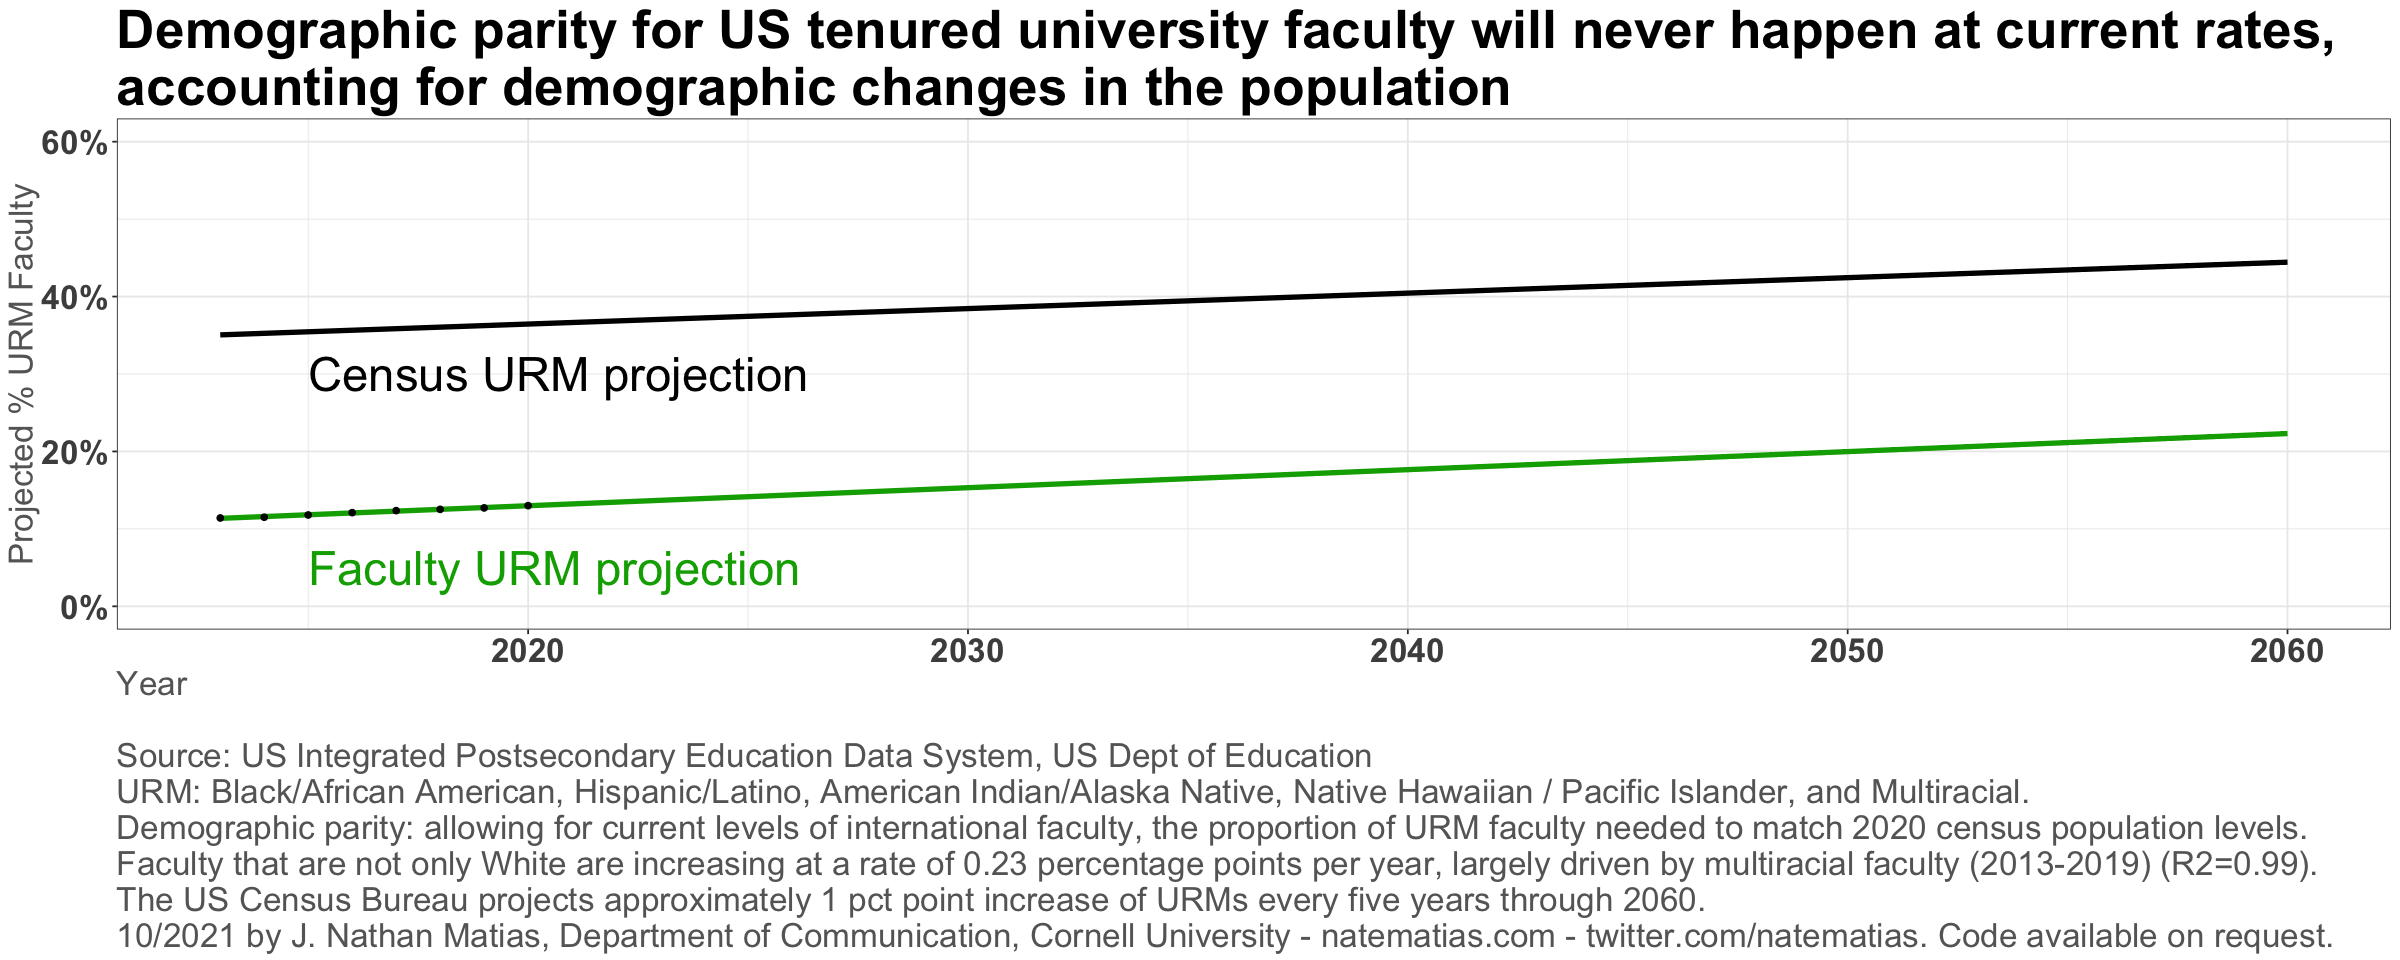

In [578]:
options(repr.plot.width=20, repr.plot.height=8)

ggplot(year.df, aes(year, tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct)) +
    geom_line(data=projection.2060.df, color="#00aa00", size=1.5) +
    geom_point() +
    geom_line(data=pop.projection.df, color="black", size=1.5) +
    annotate(geom="text", x=2015, y=0.3, label="Census URM projection",size=10, hjust=0) +
    annotate(geom="text", x=2015, y=0.05, label="Faculty URM projection",size=10, hjust=0, color="#00aa00") +
    scale_y_continuous(labels = scales::percent_format(accuracy=1), limits=c(0,0.6)) +
    scale_x_continuous(breaks=seq(2010, 2120, by=10)) +
    theme_bw() +
    theme(text         = element_text(size=20),
          plot.title   = element_text(size=32, face="bold"),
          axis.text.x  = element_text(size=20, face="bold"),
          axis.text.y  = element_text(size=20, face="bold"),
          axis.title.x = element_text(hjust=0, color="#666666"),
          axis.title.y = element_text(color="#666666")) +
    ylab("Projected % URM Faculty") +
    xlab(paste("Year\n\n",
               "Source: US Integrated Postsecondary Education Data System, US Dept of Education\n",
               "URM: Black/African American, Hispanic/Latino, American Indian/Alaska Native, Native Hawaiian / Pacific Islander, and Multiracial.\n",
               "Demographic parity: allowing for current levels of international faculty, the proportion of URM faculty needed to match 2020 census population levels.\n",
               "Faculty that are not only White are increasing at a rate of ", 
               prettyNum(summary(linear.m1)$coefficients['year.zeroed',][['Estimate']]*100, digits=2),
               " percentage points per year, largely driven by multiracial faculty (2013-2019) (R2=0.99).\n",
               "The US Census Bureau projects approximately 1 pct point increase of URMs every five years through 2060.\n",
               "10/2021 by J. Nathan Matias, Department of Communication, Cornell University - natematias.com - twitter.com/natematias. Code available on request.",
               sep="")) +
    ggtitle(paste("Demographic parity for US tenured university faculty will never happen at current rates,\n",
                  "accounting for demographic changes in the population", 
                  sep=""))


# Plot NSF Survey of Earned Doctorates against Tenure Track Faculty

In this chart, we plot the cumulative number of earned doctorates against tenure track faculty.

Data from the [NSF Survey of Earned Doctorates](https://ncses.nsf.gov/pubs/nsf22300/data-tables
), "Doctoral Recipients from U.S. Universities: 2020" file `nsf22300-tab019.xlsx` published on Oct 5, 2021.

To generate a conservative estimate of how many under-represented minorities have earned PhDs, we include only US citizen or permanent residents in the following groups:
* Hispanic or Latino
* American Indian or Alaska Native
* Black or African American
* More than one Race

Note: the Survey of Earned Doctorates does not record records for Native Hawaiian or Other Pacific Islander participants.

In [579]:
ed.df <- read.csv(paste(data.path, nsed.path,"ns22300-tab019-citizens-only.csv", sep=""), sep=",")
colnames(ed.df)

[1] "Ethnicity.race.and.citizenship.status"
 [2] "X2010"                                
 [3] "X2011"                                
 [4] "X2012"                                
 [5] "X2013"                                
 [6] "X2014"                                
 [7] "X2015"                                
 [8] "X2016"                                
 [9] "X2017"                                
[10] "X2018"                                
[11] "X2019"                                
[12] "X2020"

In [580]:
## generate a column name from a number
gencolname <- function(i){
    return(paste("X",i,sep=""))
}

## GENERATE A CUMULATIVE SUM FOR A SPECIFIC SEQUENCE OF YEARS
## Code validated against spreadsheet on Jan 7, 2022
yearsum <- function(df, min.year, max.year){
    return(sum(ed.df[,unlist(lapply(seq(min.year,max.year), FUN=gencolname))]))
}

In [581]:
## Add cumulative sums
cumulative.ed.df <- data.frame(
    sequence = "Earned URM PhDs\nSince 2010",
    year   = seq(2010, 2020),
    total  = c(yearsum(ed.df, 2010,2010),
               yearsum(ed.df, 2010,2011),
               yearsum(ed.df, 2010,2012),
               yearsum(ed.df, 2010,2013),
               yearsum(ed.df, 2010,2014),
               yearsum(ed.df, 2010,2015),
               yearsum(ed.df, 2010,2016),
               yearsum(ed.df, 2010,2017),
               yearsum(ed.df, 2010,2018),
               yearsum(ed.df, 2010,2019),
               yearsum(ed.df, 2010,2020))
)



In [582]:
## Add in all tenure track faculty

In [583]:
cumulative.tt.df<-
    data.frame(
        sequence = "URM tenure\ntrack faculty",
        year     = year.df$year,
        total    = year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum
    )

ed.year.df <- 
    rbind(cumulative.ed.df,
          cumulative.tt.df
    )

In [584]:
## do we find a correlation between the number of cumulative PhD students and employed TT faculty? No.
ed.tt.cor.1 <- cor.test(subset(cumulative.ed.df, year>=2013)$total, cumulative.tt.df$total)
ed.tt.cor.1.p <- ed.tt.cor.1$p.value
ed.tt.cor.1.p

[1] 0.162875

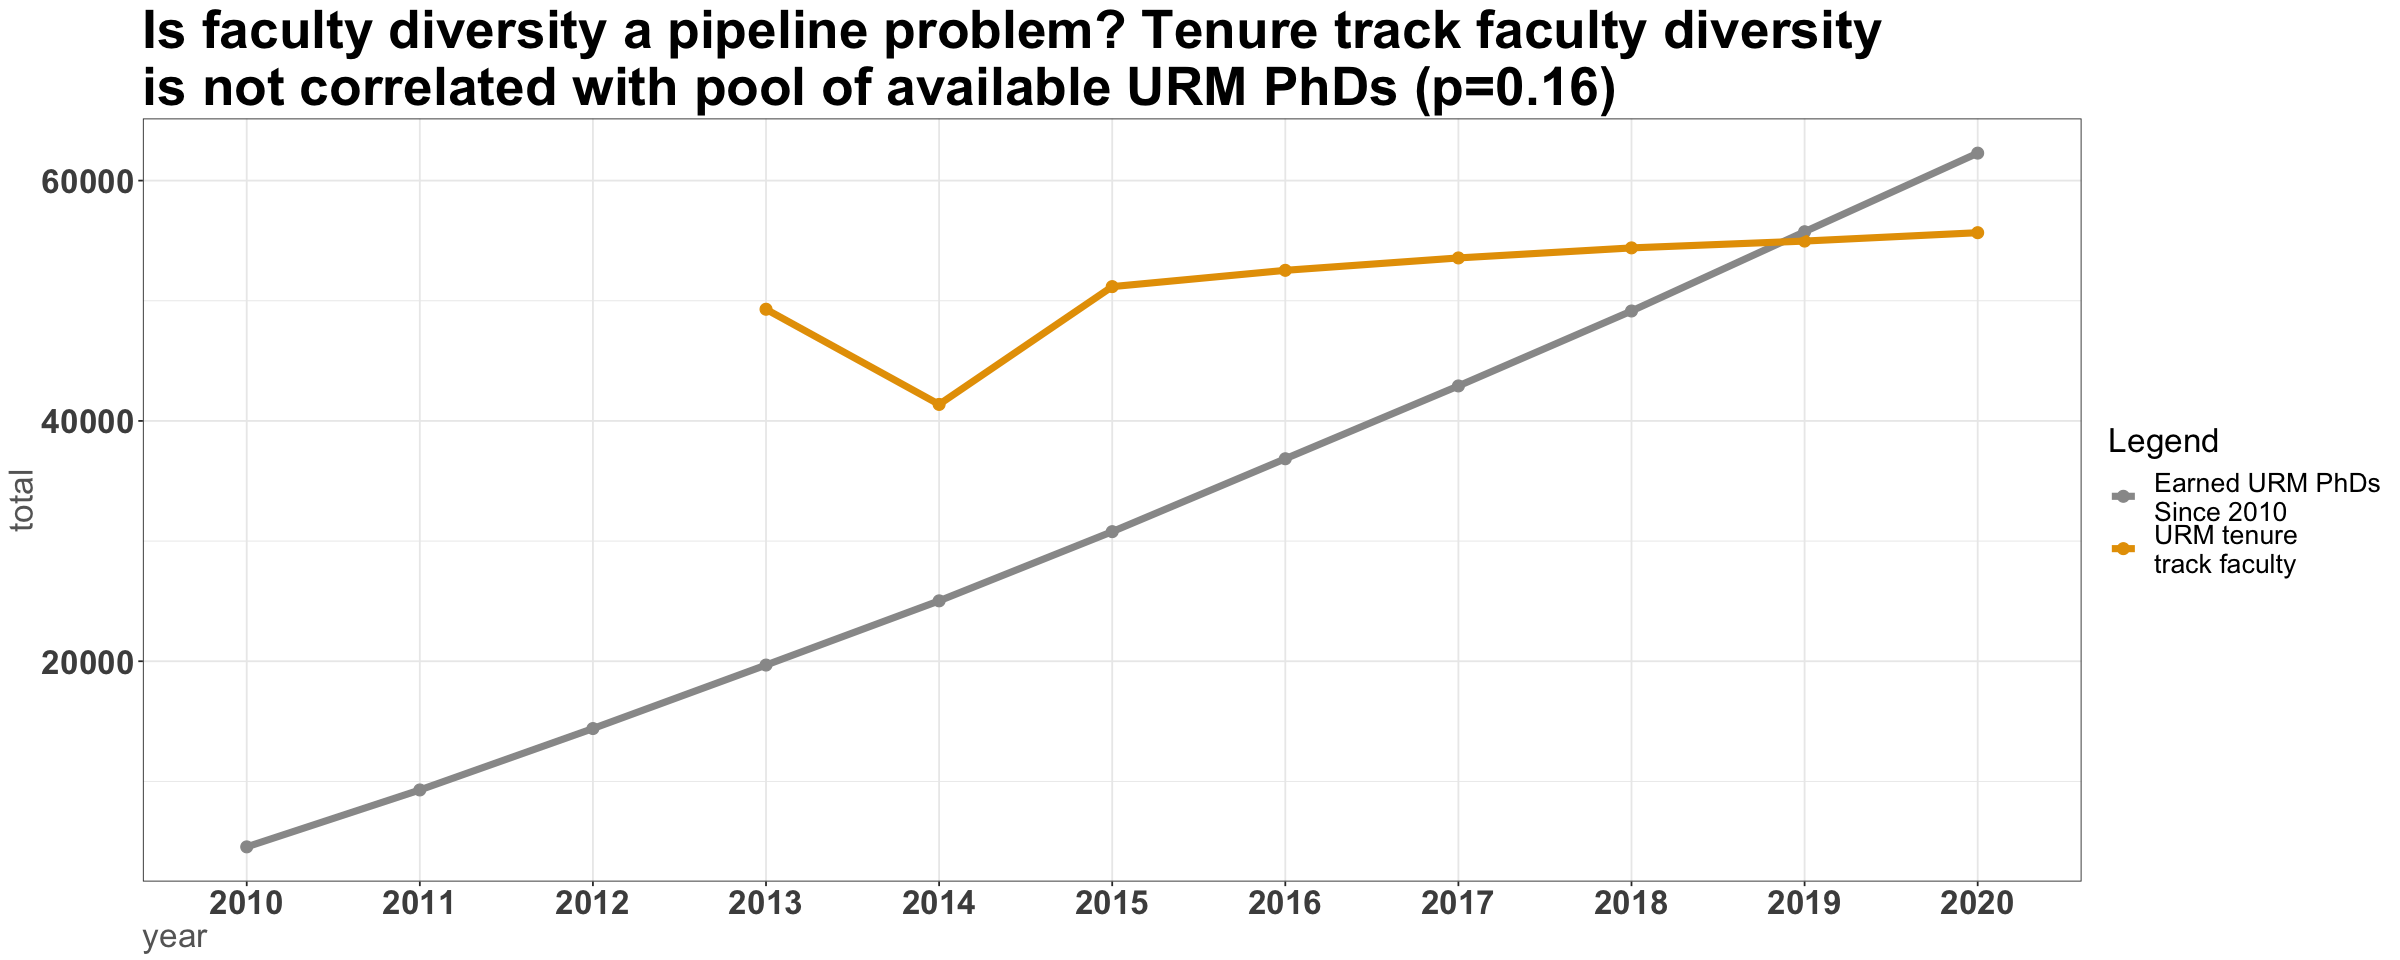

In [585]:
ggplot(ed.year.df, aes(year, total, color=sequence)) +
    geom_point(size=3) +
#    geom_smooth(method=lm, size=2) + 
    geom_line(size=2) +
    theme_bw() +
    scale_color_manual(values=cbPalette, name="Legend") +
    scale_x_discrete(limits=seq(2010,2020, 1)) +
    theme(text         = element_text(size=20),
          plot.title   = element_text(size=32, face="bold"),
          axis.text.x  = element_text(size=20, face="bold"),
          axis.text.y  = element_text(size=20, face="bold"),
          axis.title.x = element_text(hjust=0, color="#666666"),
          axis.title.y = element_text(color="#666666")) +
    ggtitle(paste("Is faculty diversity a pipeline problem? Tenure track faculty diversity\n", 
                  "is not correlated with pool of available URM PhDs (p=", prettyNum(ed.tt.cor.1.p, digits=2) ,")",
                  sep=""))

# Plot Institutions within their Category

* ~TODO: re-generate CSVs to include totals and percentages of tenured and un-tenured URM faculty, for all categories, in summaries and in models~
* ~TODO: Generate chart style ( can do that with one of the existing groups)~

## Load Data
### Load Institutional Categories

In [672]:
#within ivyplus models
ivyplus.models.df <- read.csv(paste(data.path, nces.path, generation.date, "_ivy_plus_regression_table.csv", sep=""),na.strings = "")

#ivyplus vs non ivyplus summaries
ivyplus.summary.df <- read.csv(paste(data.path, nces.path, generation.date, "_ivy_plus_summary_table.csv", sep=""),na.strings = "")

## US News used to get liberal arts colleges
#within usnews models
usnews.models.df <- read.csv(paste(data.path, nces.path, generation.date, "_usnews_regression_table.csv", sep=""),na.strings = "")

#usnews summaries
usnews.summary.df <- read.csv(paste(data.path, nces.path, generation.date, "_usnews_summary_table.csv", sep=""),na.strings = "")


In [673]:
#unique(ivyplus.models.df$dv)

### Load Institutional Statistical Models

In [674]:
institution.models.df <- read.csv(paste(data.path, nces.path, generation.date, "_institution_regression_tables.csv", sep=""),na.strings = "")
colnames(institution.models.df)

[1] "subgroup"        "subgroup_value"  "min_year"        "max_year"       
 [5] "dv"              "formula"         "Intercept"       "year_estimate"  
 [9] "year_pvalue"     "year_stderr"     "usnews_category" "ivy_plus"       
[13] "hsi_hbcu_tribal"

## Comparative plot of institutions
### IvyPlus

In [683]:
subset(ivyplus.models.df,(dv=="tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct"))

,subgroup,subgroup_value,min_year,max_year,dv,formula,Intercept,year_estimate,year_pvalue,year_stderr
1,ivy_plus,False,2012,2020,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct ~ year_num,0.10015668,0.002385112,1.103715e-07,0.0001097754
92,ivy_plus,True,2012,2020,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct ~ year_num,0.06987585,0.002209486,2.601017e-06,0.0001612711


In [678]:
dv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct"
gdv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct"
subgroup_name = "All Ivy+"

subset.institution.models.df <- subset(institution.models.df, ivy_plus=="True" & dv==dv.var)

subset.dv.df <- subset(ivyplus.models.df, (dv==gdv.var & subgroup_value=="True"))
subset.dv.df$subgroup_value = as.character(subset.dv.df$subgroup_value)

max.observed.year <- max(subset.dv.df$max_year)

In [684]:
subset.dv.df

,subgroup,subgroup_value,min_year,max_year,dv,formula,Intercept,year_estimate,year_pvalue,year_stderr
92,ivy_plus,True,2012,2020,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct ~ year_num,0.06987585,0.002209486,2.601017e-06,0.0001612711


In [693]:
## institution.projections: return a dataframe of models and projections
## for three points for a given institution:
## first point: estimated intercept for the first observed year
## second point: estimated value for the final observed year
## third point: projected value for projection.end.year (defined above)
institution.projections <- function(institution.df){

    institution.min.year <- as.numeric(substr(institution.df$min_year, 1,4))
    institution.max.year <- as.numeric(substr(institution.df$max_year, 1,4))

    df <- data.frame(
                    name = institution.df$subgroup_value,
                    year = c(institution.min.year, max.observed.year, projection.end.year),
                    estimate = c(
                                institution.df$Intercept*100,
                                institution.df$Intercept*100 + institution.df$year_estimate* (institution.max.year - institution.min.year)*100,
                                institution.df$Intercept*100 + institution.df$year_estimate* (projection.end.year - institution.min.year)*100
                    ))
    df$estimate.upper <- df$estimate + 1.96 * institution.df$year_stderr * 100
    df$estimate.lower <- df$estimate - 1.96 * institution.df$year_stderr * 100
    print(institution.df$year_stderr)
    return(df)
}

In [694]:
## Generate projections for every institution in the list
## and create a dataframe with those projections
institution.list = list()

for(i in seq(1,nrow(subset.institution.models.df))){
    i.df <- institution.projections(subset.institution.models.df[i,])
    institution.list[[i]] = i.df
}

institution.projections.df <- do.call(rbind, institution.list)

## generate projections for the group of institutions
group.projections.df <- institution.projections(subset.dv.df)
group.projections.df$name <- subgroup_name
group.projections.df

## generate projections for demographic parity target
parity.projections.df <- data.frame(
    year = c(2013, 2020, projection.end.year),
    estimate = c(urm.prop.adjusted*100 - 7*0.2,
                 urm.prop.adjusted*100,
                 urm.prop.adjusted*100 + 0.2*(projection.end.year-2020)),
    name="Demographic parity",
    focus.institution = NA
)
parity.projections.df
institution.projections.df

[1] 0.0002237772
[1] 0.0003998726
[1] 0.0004364829
[1] 0.000561823
[1] 0.0002628238
[1] 0.0005896778
[1] 0.000393918
[1] 0.001019886
[1] 0.0006375093
[1] 0.00137245
[1] 0.0003834313
[1] 0.0001612711


name,year,estimate,estimate.upper,estimate.lower
All Ivy+,2012,6.987585,7.019194,6.955976
All Ivy+,2020,8.755173,8.786783,8.723564
All Ivy+,2060,17.593116,17.624725,17.561506


year,estimate,name,focus.institution
2013,33.652,Demographic parity,NA
2020,35.052,Demographic parity,NA
2060,43.052,Demographic parity,NA


name,year,estimate,estimate.upper,estimate.lower
University of Pennsylvania,2013,6.901813,6.945673,6.857952
University of Pennsylvania,2020,8.723525,8.767386,8.679665
University of Pennsylvania,2060,19.133312,19.177172,19.089452
Princeton University,2012,6.446859,6.525234,6.368484
Princeton University,2020,8.225425,8.303800,8.147050
Princeton University,2060,17.118257,17.196632,17.039882
Stanford University,2013,6.725904,6.811454,6.640353
Stanford University,2020,7.063957,7.149508,6.978406
Stanford University,2060,8.995692,9.081242,8.910141
Brown University,2012,7.702447,7.812564,7.592329


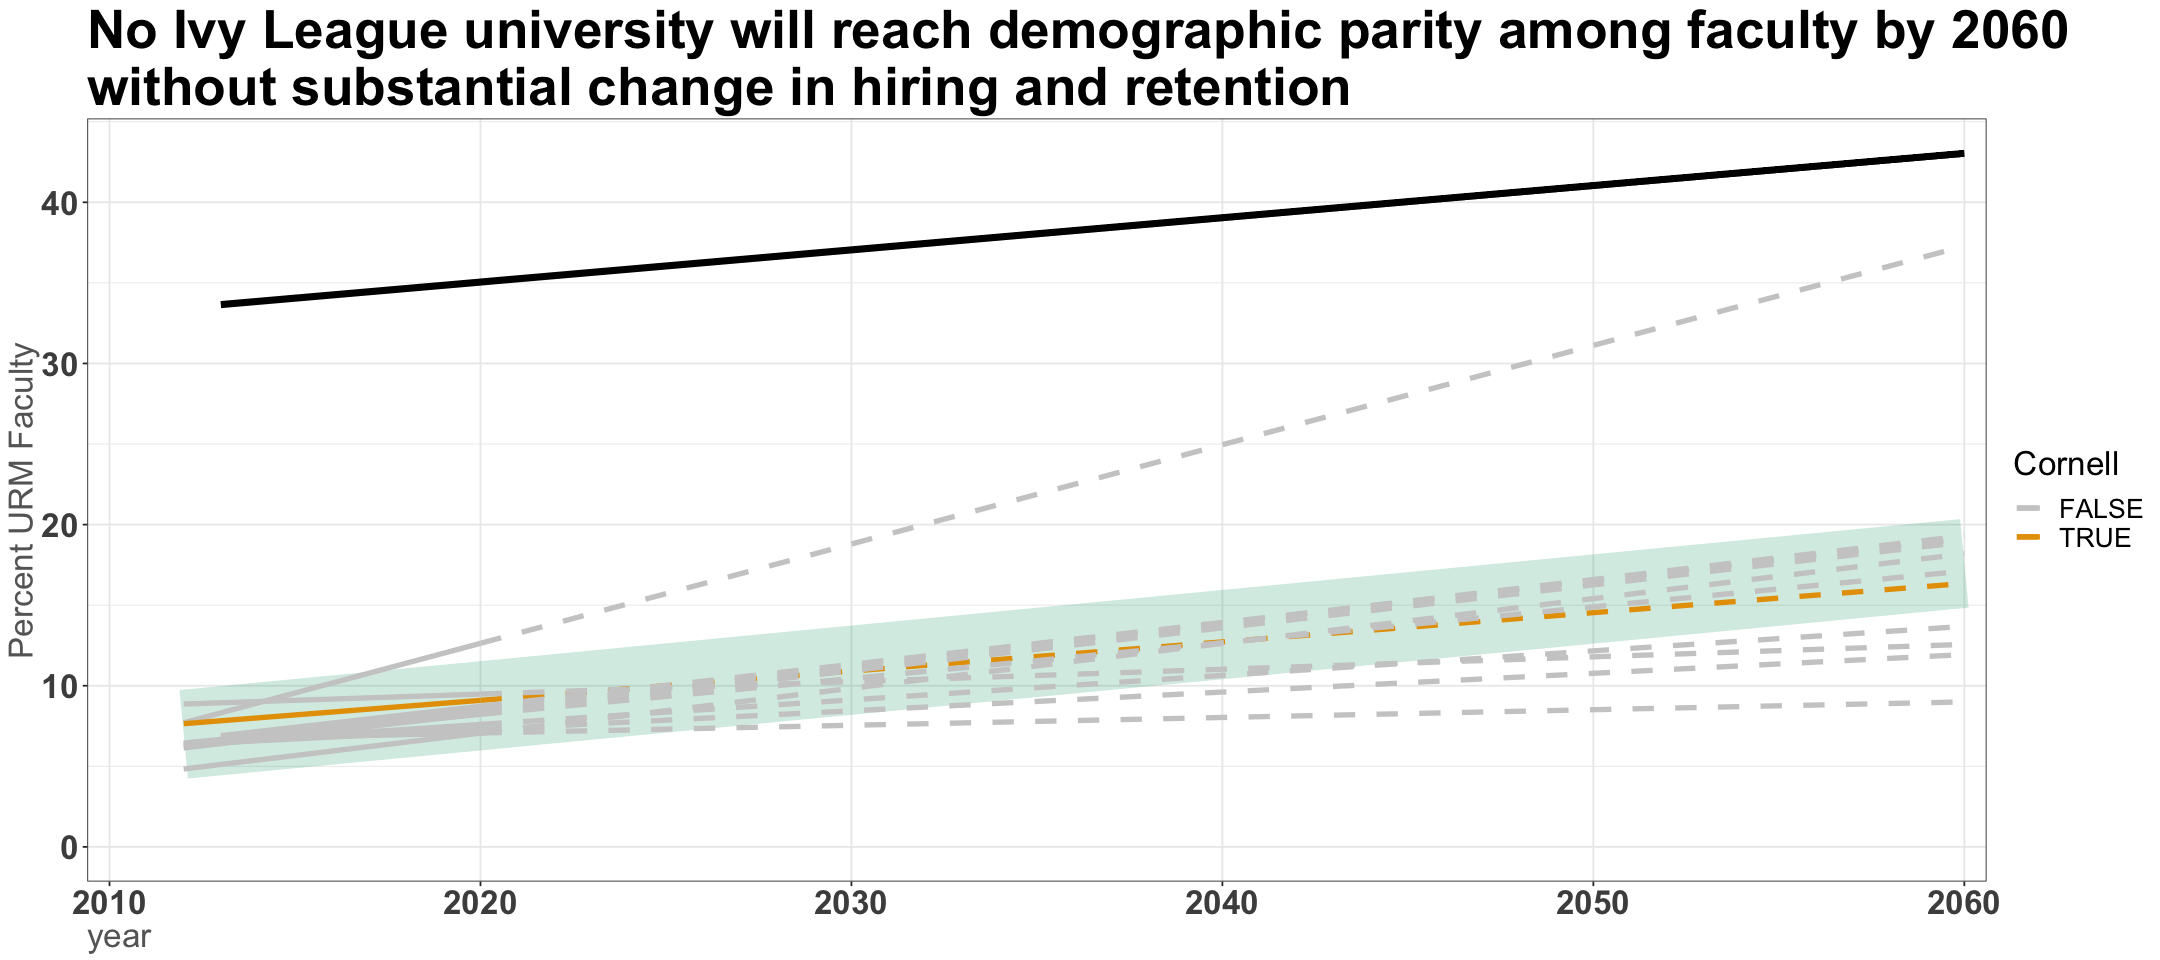

In [706]:
focus.institution <- "Cornell University"
institution.projections.df$focus.institution <- institution.projections.df$name==focus.institution

group.projections.df$focus.institution <- NA



options(repr.plot.width=18, repr.plot.height=8)

## GENERATE PLOT
ggplot(institution.projections.df, aes(year, estimate, group=name, color=focus.institution)) +
#     # subgroup lines
    geom_line(data=group.projections.df, aes(year, estimate), color=cbPalette[4], alpha=0.2, size=25) +

#     ## institution lines
    geom_line(data=subset(institution.projections.df, year<2025), size=1.5) +
    geom_line(data=subset(institution.projections.df, year>2015), size=1.5, linetype="dashed") +

    ## demograhic parity
    geom_line(data=parity.projections.df, size=2, color="black") +

    theme_bw() +
    scale_color_manual(values=c("#cccccc", "#E69F00"), name="Cornell") +
   scale_x_discrete(limits=seq(2010,projection.end.year, 10)) +
   coord_cartesian(ylim = c(0, max(parity.projections.df$estimate)), xlim = c(2010,2060)) +
    theme(text         = element_text(size=20),
          plot.title   = element_text(size=32, face="bold"),
          axis.text.x  = element_text(size=20, face="bold"),
          axis.text.y  = element_text(size=20, face="bold"),
          axis.title.x = element_text(hjust=0, color="#666666"),
          axis.title.y = element_text(color="#666666")) +
    ylab("Percent URM Faculty") +
    ggtitle(paste("No Ivy League university will reach demographic parity among faculty by 2060", "without substantial change in hiring and retention", sep="\n"))



# Output variables to file accessible by the paper

In [1]:
example.variable <- "Hello, I am example variable"

In [ ]:
save(list=ls(), file="paper-data.RData", version = 2) # overleaf uses R 3.4 which requires version 2 of Rdata I believe